In [ ]:
import qiskit
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(group='open') #check open servers

In [ ]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import random
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer)
from matplotlib import cm
%matplotlib inline

In [ ]:
def counts_to_prob_2d(counts):
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    n = int(len(states[0])/2)
    def sep_xy(states):
        # Separate x and y coordinates in state vector
        states_x = [s[:n] for s in states]
        states_y = [s[n:] for s in states]
        states_x = np.array([int(s[::-1],2) for s in states_x])
        states_y = np.array([int(s[::-1],2) for s in states_y])
        return states_x, states_y
    x,y = sep_xy(states)
    # Create array of probability values
    probabilities = np.zeros((2**n,2**n))
    probabilities[x,y] = state_counts
    probabilities /= nshots
    return probabilities

In [ ]:
def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct(qcoin[:]+qpos[i+1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        if i+1 < n: circuit.x(qpos[i+1:])
        circuit.mct(qcoin[:]+qpos[i+1:], qpos[i], None, mode='noancilla')
        if i+1 < n: circuit.x(qpos[i+1:])

def step(circuit, qpos, qcoin, cpos, simulatorType):
    circuit.h(qcoin)
    circuit.barrier()
    # y operations
    increment_gate(circuit, qpos[len(qpos)//2:], qcoin)
    circuit.x(qcoin[0])
    decrement_gate(circuit, qpos[len(qpos)//2:], qcoin)
    # x operations
    circuit.x(qcoin)
    increment_gate(circuit, qpos[:len(qpos)//2], qcoin)
    circuit.x(qcoin[0])
    decrement_gate(circuit, qpos[:len(qpos)//2:], qcoin)
    circuit.barrier()
    if simulatorType == 'classical':
        circuit.measure(qpos,cpos)
    
def initialize_2D(circuit, n, pos):
    # convert position to binary
    formatLabel = '{0:0'+str(n)+'b}'
    x = formatLabel.format(pos[0])
    y = formatLabel.format(pos[1])
    for i in range(len(x)):
        if x[i]=='1': 
            circuit.x((n-i)-1)
    for j in range(len(y)):
        if y[j]=='1': 
            circuit.x((2*n-j)-1)
    return circuit
    
def run(steps,simulatorType):
    # steps = number of quantum walks steps
    # simulatorType = 'sim', 'quantum' or 'classical'
    
    if simulatorType == 'sim':
        simulator = Aer.get_backend('qasm_simulator')
    elif simulatorType == 'quantum':
        simulator = provider.get_backend('ibmq_16_melbourne')
    elif simulatorType == 'classical':
        simulator = Aer.get_backend('qasm_simulator')
    else:
        simulator = Aer.get_backend('qasm_simulator')
        
    qpos = QuantumRegister(2*n,'qc')
    qcoin = QuantumRegister(2,'qanc')
    cpos = ClassicalRegister(2*n,'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)
    circuit = initialize_2D(circuit, n, [round(n/2),round(n/2)])
    for i in range(steps):
        step(circuit, qpos, qcoin, cpos, simulatorType)
    # # Map the quantum measurement to the classical bits
    circuit.measure(qpos,cpos)
    # # Execute the circuit on the qasm simulator
    job = execute(circuit, simulator, shots=1000)
    # monitor job
    job_monitor(job)
    # # Grab results from the job
    result = job.result()
    # # Returns counts
    counts = result.get_counts(circuit)
    return counts

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


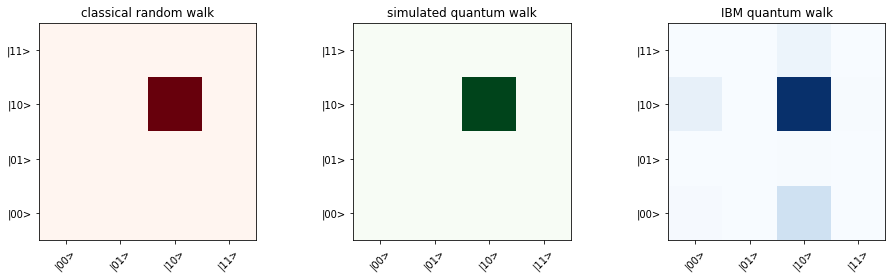

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


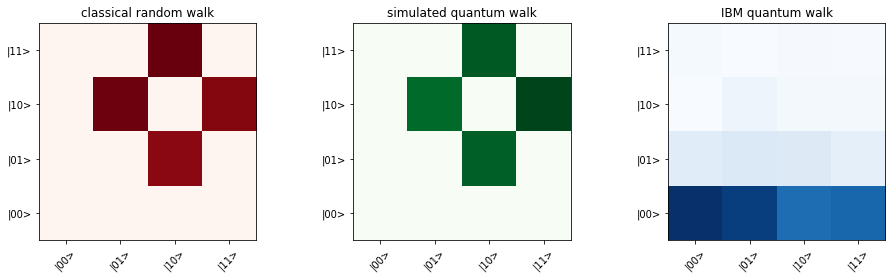

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


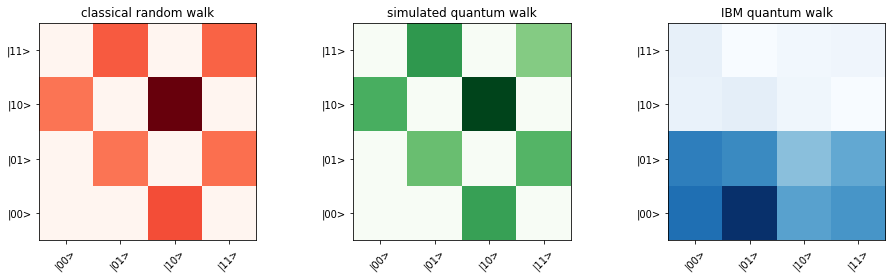

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


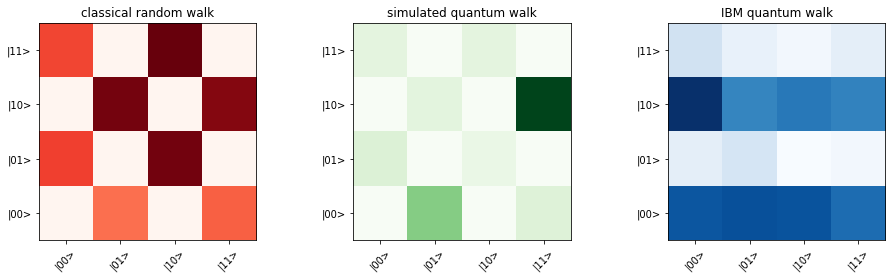

In [146]:
n=2
steps = 3

for i in range(steps+1):
    #run classical random walk
    countsClassical = run(i,'classical')
    propClassical = counts_to_prob_2d(countsClassical)
    #run quantum simulation
    countsSim = run(i,'sim')
    propSim = counts_to_prob_2d(countsSim)
    #run the real thing
    countsQuantum = run(i,'quantum')
    propQuantum = counts_to_prob_2d(countsQuantum)
    
    
    #plotting
    names = []
    values = []
    formatLabel = '{0:0'+str(n)+'b}'
    for idx in range(2**n):
        names.append('|' + formatLabel.format(idx) +'>')
        values.append(idx)

    f, axs = plt.subplots(1,3,figsize=(13,8))
    margin=0.4
    f.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
    axs[0].set_title('classical random walk')
    plt.sca(axs[0])
    plt.imshow(propClassical,cmap=plt.get_cmap('Reds'))
    plt.xticks(rotation=45)
    axs[0].set_xticks(values)
    axs[0].set_xticklabels(names)
    plt.xlim(-0.5,values[-1]+0.5) 
    axs[0].set_yticks(values)
    axs[0].set_yticklabels(names)
    plt.ylim(-0.5,values[-1]+0.5) 

    axs[1].set_title('simulated quantum walk')
    plt.sca(axs[1])
    plt.imshow(propSim,cmap=plt.get_cmap('Greens'))
    plt.xticks(rotation=45)
    axs[1].set_xticks(values)
    axs[1].set_xticklabels(names)
    plt.xlim(-0.5,values[-1]+0.5) 
    axs[1].set_yticks(values)
    axs[1].set_yticklabels(names)
    plt.ylim(-0.5,values[-1]+0.5) 

    axs[2].set_title('IBM quantum walk')
    plt.sca(axs[2])
    plt.imshow(propQuantum,cmap=plt.get_cmap('Blues'))
    plt.xticks(rotation=45)
    axs[2].set_xticks(values)
    axs[2].set_xticklabels(names)
    plt.xlim(-0.5,values[-1]+0.5) 
    axs[2].set_yticks(values)
    axs[2].set_yticklabels(names)
    plt.ylim(-0.5,values[-1]+0.5) 

    plt.tight_layout()
    plt.show()
    
    